In [3]:
### Codegen model: https://huggingface.co/docs/transformers/model_doc/codegen 
import transformers

/Users/lionelwong/miniconda3/envs/physlang/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Code transformers

In [7]:
from transformers import AutoTokenizer, CodeGenModel
import torch
tokenizer = AutoTokenizer.from_pretrained("Salesforce/codegen-2B-mono")
model = CodeGenModel.from_pretrained("Salesforce/codegen-2B-mono")


Downloading: 100%|██████████████████████████████| 240/240 [00:00<00:00, 147kB/s]
Downloading: 100%|███████████████████████████| 798k/798k [00:00<00:00, 7.69MB/s]
Downloading: 100%|███████████████████████████| 456k/456k [00:00<00:00, 5.47MB/s]
Downloading: 100%|█████████████████████████| 2.11M/2.11M [00:00<00:00, 11.6MB/s]
Downloading: 100%|██████████████████████████| 1.00k/1.00k [00:00<00:00, 624kB/s]
Downloading: 100%|███████████████████████████| 90.0/90.0 [00:00<00:00, 65.0kB/s]
Downloading: 100%|██████████████████████████████| 997/997 [00:00<00:00, 567kB/s]
Downloading: 100%|█████████████████████████| 5.69G/5.69G [06:40<00:00, 14.2MB/s]
Some weights of the model checkpoint at Salesforce/codegen-2B-mono were not used when initializing CodeGenModel: ['lm_head.bias', 'lm_head.weight']
- This IS expected if you are initializing CodeGenModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a 

In [30]:
inputs = tokenizer("Test prompt There is a red block on the table", return_tensors="pt")
total_length = inputs['input_ids'].size()[-1]
outputs = model(**inputs)
last_hidden_states = outputs.last_hidden_state
print(last_hidden_states[:, 2:total_length, :].size()[1])
torch.mean(last_hidden_states[:, 2:total_length, :], 1).squeeze().size()

8


torch.Size([2560])

In [ ]:
# Embeddings with and without a prompt.
prompt = "Test prompt."
sentences = ["There is a red block on the table", 
             "The table has a red block on it", 
             "A table with a red block",
             "Not all of the blocks on the table are red",
             "Some blocks on the table are red",
             "Dogs are cute",
             "A cute dog",
              "Look at this dog"]

def get_embeddings(sentences, prompt):
    sentence_embeddings = []
    sentence_lengths = []
    # Calculate the embedding length of the prompt.
    tokens_in_prompt = tokenizer(prompt, return_tensors="pt")
    len_tokens_in_prompt = tokens_in_prompt['input_ids'].size()[-1]
    for idx, sentence in enumerate(sentences):
        print(f"Now on sentence {idx}/{len(sentences)}")
        inputs = tokenizer(prompt + sentence, return_tensors="pt")
        total_text_length = inputs['input_ids'].size()[-1]
        outputs = model(**inputs)
        last_hidden_states = outputs.last_hidden_state
        sentence_last_hidden_states = last_hidden_states[:, len_tokens_in_prompt:total_text_length, :]
        sentence_length = sentence_last_hidden_states.size()[1]
        sentence_embedding = torch.mean(sentence_last_hidden_states, 1).squeeze().detach().numpy()
        sentence_embeddings.append(sentence_embedding)
        sentence_lengths.append(sentence_length)
    return sentence_embeddings, sentence_lengths

e, l = get_embeddings(sentences, prompt)

Now on sentence 0/8
Now on sentence 1/8
Now on sentence 2/8
Now on sentence 3/8
Now on sentence 4/8
Now on sentence 5/8
Now on sentence 6/8
Now on sentence 7/8


#### TSNE Visualization

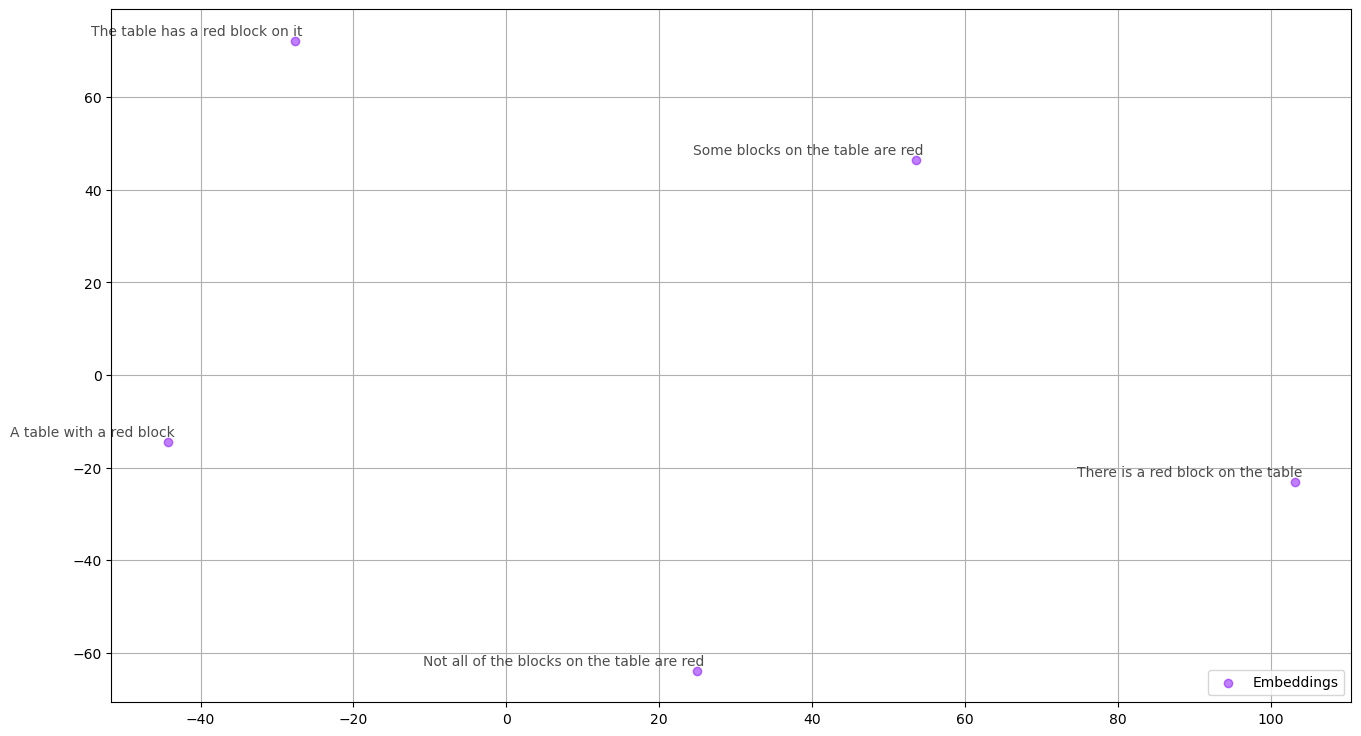

In [59]:
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline


def tsne_plot_2d(title, sentences, embeddings, a=1):
    tsne_2d = TSNE(perplexity=min(len(sentences) - 1, 15), n_components=2, init='pca', n_iter=3500, random_state=32)
    embeddings_2d = tsne_2d.fit_transform(np.array(embeddings))
    plt.figure(figsize=(16, 9))
    colors = cm.rainbow(np.linspace(0, 1, 1))
    x = [x for x,y in embeddings_2d]
    y = [y for x,y in embeddings_2d]
    plt.scatter(x, y, c=colors, alpha=a, label=title)
    for i, s in enumerate(sentences):
        plt.annotate(s, alpha=0.7, xy=(x[i], y[i]), xytext=(5, 2), 
                     textcoords='offset points', ha='right', va='bottom', size=10)
    plt.legend(loc=4)
    plt.grid(True)
    plt.show()

tsne_plot_2d('Embeddings', sentences=sentences, embeddings=e, a=0.5)